In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
from numba import njit,jit
import torch

CIFAR-10

In [96]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [97]:
# Extract all images and labels
train_images_tensor, train_labels_tensor = next(iter(train_loader))

# Convert tensors to NumPy arrays
train_images = train_images_tensor.numpy()  
train_label = train_labels_tensor.numpy()  

In [98]:
test_images = []
test_labels = []

for images, labels in test_loader:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

# Concatenate into full NumPy arrays
test_images = np.concatenate(test_images, axis=0)   
test_labels = np.concatenate(test_labels, axis=0)   

In [99]:
print(train_images.shape)
print(test_images.shape)

(5000, 3, 32, 32)
(10000, 3, 32, 32)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

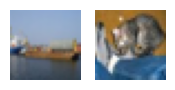

In [100]:
f,ax=plt.subplots(1,2,figsize=(2,2))
ax[0].imshow(np.transpose(train_images[0],(1,2,0)),cmap='gray')
ax[1].imshow(np.transpose(test_images[0],(1,2,0)),cmap='gray')
ax[0].axis('off')
ax[1].axis('off')

Convolutional Layer

In [7]:
@jit(nopython=True)
def convolution(X,stride,kernel_size,out_channels,kernels,b):
        
        #X.shape -> (depth,h,w)
        rows=int((X.shape[1]-kernel_size)/stride + 1)
        cols=int((X.shape[2]-kernel_size)/stride + 1)

        output=np.zeros((out_channels,rows,cols)) #output after convolution
        
        for k in range(out_channels):
            for i in range(rows):
                for j in range(cols):
                    region = X[:, i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size]
                    output[k, i, j] = np.sum(region * kernels[k]) + b[k]


        return output

@jit(nopython=True)
def leaky_relu_derivative(x):
    return np.where(x > 0, 1, 0.01)

@jit(nopython=True)
def relu_derivative(x):
    return np.where(x > 0)

@njit
def manual_flip_kernels(kernels):
    out_ch, in_ch, kH, kW = kernels.shape
    flipped = np.empty_like(kernels)
    for o in range(out_ch):
        for i in range(in_ch):
            for h in range(kH):
                for w in range(kW):
                    flipped[o, i, h, w] = kernels[o, i, kH - 1 - h, kW - 1 - w]
    return flipped

@njit
def pad_dZ(dZ, pad_h, pad_w):
    C, H, W = dZ.shape
    padded = np.zeros((C, H + 2 * pad_h, W + 2 * pad_w), dtype=dZ.dtype)
    
    for c in range(C):
        for i in range(H):
            for j in range(W):
                padded[c, i + pad_h, j + pad_w] = dZ[c, i, j]
                
    return padded


@jit(nopython=True)
def backward_c(dZ,learning_rate,is_last_layer,kernels,b,X,pre_activation,kernel_size,out_channels,input_channels,stride):
        
        d_kernels = np.zeros_like(kernels) #to store derivative of each kernel
        d_b = np.zeros_like(b) #to store derivative of each bias
        d_X=np.zeros_like(X) #to store derivative of input to this layer
        
        if not is_last_layer:
            if dZ.shape!=pre_activation.shape:
                pre_activation=pre_activation[:,:dZ.shape[1],:dZ.shape[2]]
            dZ=dZ*leaky_relu_derivative(pre_activation)
        
        #padding dz for gradient of dX
        padded_dz = pad_dZ(dZ,kernel_size-1,kernel_size-1)

        
        rotated_kernels= manual_flip_kernels(kernels) #for derivative of dl/dx
        
        for k in range(out_channels):
            for c in range(input_channels):
                for i in range(dZ.shape[1]):
                    for j in range(dZ.shape[2]):
                        region = X[c, i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size]
                        d_kernels[k, c] += dZ[k, i, j] * region
            d_b[k] = np.sum(dZ[k])



        for c in range(input_channels):
            for k in range(out_channels):
                for i in range(d_X.shape[1]):
                    for j in range(d_X.shape[2]):
                        region = padded_dz[k, i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size]
                        if region.shape != (kernel_size, kernel_size):
                            continue
                        d_X[c, i, j] += np.sum(region * rotated_kernels[k, c])

    

        kernels-=learning_rate*d_kernels
        b-=learning_rate*d_b
      
        return d_X,kernels,b

class Conv2D:
    def __init__(self,input_channels,out_channels,kernel_size,stride,load,params):
        
        self.input_channels=input_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size
        self.stride=stride

        #initialising weights
        if not load:
            scale = np.sqrt(2 / (input_channels * kernel_size * kernel_size))
            self.kernels=np.random.randn(out_channels,input_channels,kernel_size,kernel_size)*scale
            self.b=np.zeros(out_channels)
        else:
            #load saved parameters
            self.kernels=params['kernels'].copy()
            self.b=params['b'].copy()
        
    def get_params(self):
        return self.kernels,self.b
    def relu(self,x):
        return np.maximum(0,x)
    def leaky_relu(self,z):
        return np.where(z > 0, z, 0.01 * z)
    def forward(self,X,is_last_layer):
        
        self.X=X 
        self.z=convolution(X,self.stride,self.kernel_size,self.out_channels,self.kernels,self.b)
        self.pre_activation=self.z
        
        if not is_last_layer:
            self.z= self.relu(self.z)
        
        return self.z
    
    def backward(self,dZ,learning_rate,is_last_layer):
        dX,kernels,b=backward_c(dZ,learning_rate,is_last_layer,self.kernels,self.b,self.X,self.pre_activation
                              ,self.kernel_size,self.out_channels,self.input_channels,self.stride)
        self.kernels=kernels.copy()
        self.b=b.copy()
        return dX

In [8]:
@jit(nopython=True)
def deconvolution(X,stride,kernel_size,out_channels,b,kernels):
        rows = int((X.shape[1] - 1) * stride + kernel_size)
        cols = int((X.shape[2] - 1) * stride + kernel_size)

        output = np.zeros((out_channels, rows, cols))

        for i in range(X.shape[1]):
            for j in range(X.shape[2]):
                x_slice = X[:, i, j]  
                for k in range(out_channels):
                    output[k, i*stride:i*stride+kernel_size,
                            j*stride:j*stride+kernel_size] += \
                            np.sum(x_slice[:, None, None] * kernels[k], axis=0)
                    output[k]+=b[k]
        return output

@jit(nopython=True)
def relu_derivative(x):
    return np.where(x > 0)
   
@njit
def manual_flip_kernels(kernels):
    out_ch, in_ch, kH, kW = kernels.shape
    flipped = np.empty_like(kernels)
    for o in range(out_ch):
        for i in range(in_ch):
            for h in range(kH):
                for w in range(kW):
                    flipped[o, i, h, w] = kernels[o, i, kH - 1 - h, kW - 1 - w]
    return flipped

@jit(nopython=True)
def leaky_relu_derivative(x):
    return np.where(x > 0, 1, 0.01)


@jit(nopython=True)
def backward_d(dZ, learning_rate,is_last_layer,kernels,b,X,pre_activation,out_channels,stride,kernel_size):
        d_kernels = np.zeros_like(kernels)
        d_b = np.zeros_like(b)
        d_X = np.zeros_like(X)

        rotated_kernels = manual_flip_kernels(kernels)
        
        if not is_last_layer: 
            dZ=dZ*leaky_relu_derivative(pre_activation)

        for i in range(X.shape[1]):
            for j in range(X.shape[2]):
                x_val = X[:, i, j]  # shape: (input_channels,)
                for k in range(out_channels):
                    region = dZ[k, i*stride:i*stride+kernel_size,
                                j*stride:j*stride+kernel_size]
                    
                    if region.shape != (kernel_size, kernel_size):
                        continue

                    d_kernels[k] += x_val[:, None, None] * region
                    d_X[:, i, j] += np.sum(np.sum(rotated_kernels[k] * region, axis=2), axis=1)

        d_b = np.sum(np.sum(dZ, axis=1), axis=1)

        # Update
        kernels-=learning_rate*d_kernels
        b-=learning_rate*d_b
        
        return d_X,kernels,b           

class ConvTranspose2D:
    def __init__(self,input_channels,out_channels,kernel_size,stride,load,params):
        
        self.input_channels=input_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size
        self.stride=stride

        #initialising weights
        if not load:
            scale = np.sqrt(2 / (input_channels * kernel_size * kernel_size))
            self.kernels=np.random.randn(out_channels,input_channels,kernel_size,kernel_size)*scale
            self.b=np.zeros((out_channels,1))
        else:
            #load saved parameters
            self.kernels=params['kernels'].copy()
            self.b=params['b'].copy()

    def get_params(self):
        return self.kernels,self.b  
    def relu(self,x):
        return np.maximum(0,x)
    def leaky_relu(self,z):
        return np.where(z > 0, z, 0.01 * z)
    
    def forward(self,X,is_last_layer):
        self.X=X
        self.z=deconvolution(X,self.stride,self.kernel_size,self.out_channels,self.b,self.kernels)
        self.pre_activation=self.z
        if not is_last_layer:
            self.z=self.relu(self.z)
        
        return self.z
    
    
    def backward(self,dZ,learning_rate,is_last_layer):
        dX,kernels,b=backward_d(dZ,learning_rate,is_last_layer,self.kernels,self.b,self.X,self.pre_activation
                              ,self.out_channels,self.stride,self.kernel_size)
        
        self.kernels=kernels.copy()
        self.b=b.copy()
        
        return dX

In [9]:
@jit(nopython=True)
def forward_p(X,kernel_size,stride):
        C, H, W = X.shape

        h_out = int((H - kernel_size) / stride + 1)
        w_out = int((W - kernel_size) / stride + 1)

        output = np.zeros((C, h_out, w_out))

        for c in range(C):
            for i in range(h_out):
                for j in range(w_out):
                    h_start = i * stride
                    w_start = j * stride
                    window = X[c, h_start:h_start + kernel_size, w_start:w_start + kernel_size]
                    max_n=np.max(window)
                    output[c, i, j] = max_n

        return output

@njit   
def backward_p(X,stride):
    C, H, W = X.shape
    H_new, W_new = H * stride, W * stride
    upsampled = np.zeros((C, H_new, W_new))

    for c in range(C):
        for i in range(H_new):
            for j in range(W_new):
                # Map coordinates back to original image space
                x = (i / stride)
                y = (j / stride)

                x0 = int(np.floor(x))
                x1 = np.minimum(x0 + 1, H - 1)
                y0 = int(np.floor(y))
                y1 = np.minimum(y0 + 1, W - 1)

                dx = x - x0
                dy = y - y0

                # Bilinear interpolation
                top = (1 - dy) * X[c, x0, y0] + dy * X[c, x0, y1]
                bottom = (1 - dy) * X[c, x1, y0] + dy * X[c, x1, y1]
                value = (1 - dx) * top + dx * bottom

                upsampled[c, i, j] = value

    return upsampled

class MaxPool2D:
    def __init__(self, kernel_size, stride):
        self.kernel_size = kernel_size
        self.stride = stride
    
    def forward(self,X,dummy):
      
        return forward_p(X,self.kernel_size,self.stride)
    
    def backward(self,X,learning_rate,dummy):
        return backward_p(X,self.stride)
   

In [10]:
@njit
def forward(X,stride):
    C, H, W = X.shape
    H_new, W_new = H * stride, W * stride
    upsampled = np.zeros((C, H_new, W_new))

    for c in range(C):
        for i in range(H_new):
            for j in range(W_new):
                # Map coordinates back to original image space
                x = i / stride
                y = j / stride

                x0 = int(np.floor(x))
                x1 = min(x0 + 1, H - 1)
                y0 = int(np.floor(y))
                y1 = min(y0 + 1, W - 1)

                dx = x - x0
                dy = y - y0

                # Bilinear interpolation
                top = (1 - dy) * X[c, x0, y0] + dy * X[c, x0, y1]
                bottom = (1 - dy) * X[c, x1, y0] + dy * X[c, x1, y1]
                value = (1 - dx) * top + dx * bottom

                upsampled[c, i, j] = value

    return upsampled
    
@jit(nopython=True)
def backward(X,kernel_size,stride):
    C, H, W = X.shape

    h_out = int((H - kernel_size) / stride + 1)
    w_out = int((W - kernel_size) / stride + 1)

    output = np.zeros((C, h_out, w_out))

    for c in range(C):
        for i in range(h_out):
            for j in range(w_out):
                h_start = i * stride
                w_start = j * stride
                window = X[c, h_start:h_start + kernel_size, w_start:w_start + kernel_size]
                max_n=np.max(window)
                output[c, i, j] = max_n

    return output


class MaxUnPool2D:
    def __init__(self,kernel_size,stride):
        self.kernel_size=kernel_size
        self.stride=stride

    def forward(self,X,indices):
        return forward(X,self.stride)
    
    def backward(self,X,learning_rate,dummy):
        return backward(X,self.kernel_size,self.stride)

In [101]:
class Convautoencoder:
    def __init__(self,load,params_c,params_d):

        self.encoder = [
            Conv2D(input_channels=3,out_channels=16,kernel_size=3,stride=1,load=load,params=params_c[0]),  
            Conv2D(input_channels=16,out_channels=32,kernel_size=3,stride=1,load=load,params=params_c[1]), 
            MaxPool2D(2,2),
            Conv2D(input_channels=32,out_channels=64,kernel_size=3,stride=1,load=load,params=params_c[2]),             
        ]

        self.decoder = [

            ConvTranspose2D(input_channels=64,out_channels=32,kernel_size=3,stride=1,load=load,params=params_d[0]),
            MaxUnPool2D(2,2),
            ConvTranspose2D(input_channels=32,out_channels=16,kernel_size=3,stride=1,load=load,params=params_d[1]),
            ConvTranspose2D(input_channels=16,out_channels=3,kernel_size=3,stride=1,load=load,params=params_d[2]),
        ]

    def sigmoid(self,X):
        return 1 / (1 + np.exp(-X))
    
    
    def get_params(self):
        params_conv,params_deconv=[],[]
        for i,layer in enumerate(self.encoder):
            if not isinstance(layer,MaxPool2D):
                kernels,b=layer.get_params()
                params_conv.append({'kernels':kernels,'b':b})
                
        for i,layer in enumerate(self.decoder):
            if not isinstance(layer,MaxUnPool2D):
                kernels,b=layer.get_params()
                params_deconv.append({'kernels':kernels,'b':b})
                
                     
        return params_conv,params_deconv
    
    def forward(self, X):
    
        #for skip-conections
        self.encoder_activations = []
        self.indices=[] 
        
        # Encoder
        for layer in self.encoder:
            X=layer.forward(X,False)
            if isinstance(layer, Conv2D):
                self.encoder_activations.append(X.copy())
            
        # Decoder
        skip_index = len(self.encoder_activations) - 1
        for i, layer in enumerate(self.decoder):
            if isinstance(layer, ConvTranspose2D):
                if skip_index >= 0:
                    skip = self.encoder_activations[skip_index]
                    
                    if X.shape != skip.shape:
                        X=skip[:,:skip.shape[1],:skip.shape[2]]
                    X += skip

                    skip_index -= 1
                
                if i!=len(self.decoder)-1:
                    X = layer.forward(X,False)
                else:
                    X = layer.forward(X,True)
            
        X = self.sigmoid(X)
        return X
    
    def backward(self, dz, learning_rate):

        # Decoder backward pass
        for i, layer in enumerate(reversed(self.decoder)):
            
                if i==0:
                    dz = layer.backward(dz, learning_rate,True)
                    
                else:
                    dz = layer.backward(dz, learning_rate,False)
                    
                    

        # Encoder backward pass
        for i, layer in enumerate(reversed(self.encoder)):

            dz = layer.backward(dz, learning_rate,False)
            #print(dz.max(),dz.min())

    def cal_err(self,z,gt):
        return np.mean((z-gt)**2)
    
    def sig_derivative(self,x):
        return x * (1 - x)

    def train(self,x,gt,learning_rate,n_samples):
        z=self.forward(x)

        if z.shape != gt.shape:
            gt=gt[:,:z.shape[1],:z.shape[2]] #clipping to match output dimensions if mismatch occurs a little

        train_loss= self.cal_err(z,gt) #mean-squared error

        dz=(2*(z-gt))/n_samples #derivative of MSE
        dz*=self.sig_derivative(z) 
        self.backward(dz,learning_rate)
        
        return train_loss
    
    def test(self, X):
        return self.forward(X)
    
    def val_test(self,X):

        z = self.forward(X)

        if z.shape != X.shape:
            X=X[:,:z.shape[1],:z.shape[2]] 

        val_loss= self.cal_err(z,X) 

        return val_loss
        

In [13]:
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy = image + noise
    noisy = np.clip(noisy, 0, 1)
    return noisy

In [102]:
# adding gaussian noise
val_set=[]
for i in range(10):
    val_image=test_images[i]
    val_image=add_gaussian_noise(val_image)
    val_set.append(val_image)

In [103]:
#to save parameters of model
params_c,params_d=[],[]
n_c=3


for i in range(n_c):
    params_c.append({'kernels':None,'b':None})
    params_d.append({'kernels':None,'b':None})

In [ ]:
model=Convautoencoder(load=False,params_c=params_c,params_d=params_d)

epochs=10

running_loss=0
n=1000
wait=0
patience=5
best_loss=float('inf')

for epoch in range(epochs):
    running_loss=0  
    val_loss=0

    for i in range(n):
        image=train_images[i]   
        noisy_img=add_gaussian_noise(image)
        loss=model.train(noisy_img,image,0.001,n)       
        running_loss+=loss

    for j in range(len(val_set)):
        val_loss+=model.val_test(val_set[j])
    val_loss/=len(val_set)

    if val_loss<best_loss:
        best_loss=val_loss
        wait=0
    else:
        wait+=1
        if wait>=patience:
            print("early stopping triggerd")
            break
        
    if epoch%1==0:
        print(f"epoch : {epoch+1} , avg training loss : {running_loss/n:.4f} , avg validation loss : {val_loss:.4f}")
        

epoch : 1 , avg training loss : 0.2171 , avg validation loss : 0.1837
epoch : 2 , avg training loss : 0.1616 , avg validation loss : 0.1381
epoch : 3 , avg training loss : 0.1233 , avg validation loss : 0.1069
epoch : 4 , avg training loss : 0.0969 , avg validation loss : 0.0852
epoch : 5 , avg training loss : 0.0783 , avg validation loss : 0.0697
epoch : 6 , avg training loss : 0.0648 , avg validation loss : 0.0583
epoch : 7 , avg training loss : 0.0548 , avg validation loss : 0.0497
epoch : 8 , avg training loss : 0.0471 , avg validation loss : 0.0431
epoch : 9 , avg training loss : 0.0412 , avg validation loss : 0.0378
epoch : 10 , avg training loss : 0.0364 , avg validation loss : 0.0336


In [ ]:
#get model
params_c,params_d=model.get_params()

# Flatten and save
np.savez("params1.npz",
**{f"c_{i}_kernels": layer["kernels"] for i, layer in enumerate(params_c)},
**{f"c_{i}_b": layer["b"] for i, layer in enumerate(params_c)},
**{f"d_{i}_kernels": layer["kernels"] for i, layer in enumerate(params_d)},
**{f"d_{i}_b": layer["b"] for i, layer in enumerate(params_d)})
print("model saved")  

model saved


In [104]:
# Load file
data = np.load("params1.npz")

# Reconstruct params_c
params_c = [
    {"kernels": data[f"c_{i}_kernels"], "b": data[f"c_{i}_b"]}
    for i in range(len([key for key in data if key.startswith("c_")]) // 2)
]

# Reconstruct params_d
params_d = [
    {"kernels": data[f"d_{i}_kernels"], "b": data[f"d_{i}_b"]}
    for i in range(len([key for key in data if key.startswith("d_")]) // 2)
]


In [142]:
#testing the model
test_set=[]
for i in range(20,27):
    test_image=test_images[i]
    test_image=add_gaussian_noise(test_image)
    test_set.append(test_image)

In [139]:
#testing the model
test_model=Convautoencoder(load=True,params_c=params_c,params_d=params_d)

In [143]:
results=[]
for i in range(len(test_set)):
    results.append(test_model.test(test_set[i]))

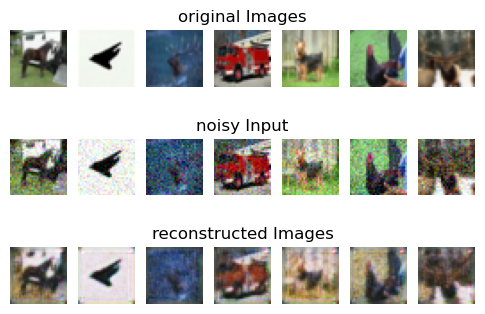

In [148]:
fig,axs=plt.subplots(3,7,figsize=(6,4))
ax=axs.flatten()

j=0
ax[j+3].set_title('original Images')
    
for i in range(20,27):
    ax[j].imshow(np.transpose(test_images[i],(1,2,0)),cmap='gray')
    ax[j].axis('off')
    j+=1

ax[j+3].set_title('noisy Input')

for i in range(7):
    ax[j].imshow(np.transpose(test_set[i],(1,2,0)),cmap='gray')
    ax[j].axis('off')
    j+=1
    
ax[j+3].set_title('reconstructed Images')
    
for i in range(7):
    ax[j].imshow(np.transpose(results[i],(1,2,0)),cmap='gray')
    ax[j].axis('off')
    
    j+=1

